https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4

In [1071]:
from intake.catalog import Catalog
from intake.catalog.local import LocalCatalogEntry
from intake.source.csv import CSVSource
import intake
from sklearn.pipeline import make_pipeline
import pandas as pd 
from dask_ml.preprocessing import Categorizer, DummyEncoder ,MinMaxScaler
import dask.dataframe as dd
from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn import random_projection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


from matplotlib import pyplot
import random


import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve, ShuffleSplit, validation_curve
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from category_encoders.one_hot import OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler

from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV ,cross_validate
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import average_precision_score , silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import time
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 100)
pd.set_option('display.expand_frame_repr', True)

## import catalogue 

In [1072]:
cat = intake.open_catalog('ml_data.yaml')

## Liver 

In [1141]:
StandardScaler?

In [1142]:
liver_df =cat.liver.read()
liver_df.drop_duplicates(inplace=True)
impute_Albumin_and_Globulin_Ratio = liver_df[~liver_df.Albumin_and_Globulin_Ratio.isna()].Albumin_and_Globulin_Ratio.mean()
filt_ =  liver_df.Albumin_and_Globulin_Ratio.isna()
liver_df.loc[filt_, "Albumin_and_Globulin_Ratio" ]= impute_Albumin_and_Globulin_Ratio
assert sum(liver_df.Albumin_and_Globulin_Ratio.isna()) == 0 
# format response 
liver_df.loc[(liver_df.Dataset ==2), "Dataset" ] = 0
liver_df.head(10)
liver_df.loc[:,"Gender"] = pd.get_dummies(liver_df.Gender, prefix='gender').drop("gender_Male", axis =1  ).gender_Female
X = liver_df.loc[:, "Age":"Albumin_and_Globulin_Ratio"]
y = liver_df["Dataset"]
# l_data = StandardScaler().fit_transform(X)

## Census 

In [1140]:
liver_df.Dataset.sum()/liver_df.shape[0]

0.712280701754386

In [782]:
sum(census_df.income=="?")

0

In [1136]:
7839/24698

0.317394120981456

In [1135]:
census_df.groupby("income").count()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
income,,,,,,,,,,,,,,
<=50K,24698,23053,24698,24698,24698,24698,23046,24698,24698,24698,24698,24698,24698,24262
>50K,7839,7648,7839,7839,7839,7839,7648,7839,7839,7839,7839,7839,7839,7693


In [1202]:
census_df =cat.adult.read()
census_df.drop_duplicates(inplace=True)
# # Deleting duplicates 
census_df.duplicated().sum()
#Replacing '?' for nans
census_df = census_df.replace('?', np.NaN)
# Mapping already our target variable in  1 and 0.

# census_df.income = census_df.income.map({'<=50K':0, '>50K':1})

X_c= census_df.drop('income', axis=1)

y_c = census_df[['income']]

y_c.income = y_c.income.map({'<=50K':0, '>50K':1})

categorical_columns= X_c.select_dtypes(object).columns

pca_census_steps = [('encoding', OneHotEncoder(cols=categorical_columns)),
         ('imputer',SimpleImputer(missing_values=np.NaN, strategy='most_frequent'))]
pca_census_pipeline = Pipeline(pca_census_steps)
pca_census_pipeline.fit(X_c)
pca_census_pipeline
c_data = pca_census_pipeline.transform(X_c)

## Expectation Maximization

In [513]:
gm = GaussianMixture(n_components=3)
gm.fit_predict(l_data)
silhouette_score(l_data, gm.fit_predict(l_data))

0.19373754294025738

## Helpers

In [535]:
GaussianMixture?

In [1066]:
def get_k_em(k, data):
    scores = []
    for i in range(2,k):
        gm = GaussianMixture(n_components=i, warm_start=True)
        pred = gm.fit_predict(data)
        score = silhouette_score(data, pred)
        scores.append((i,score))
    df= pd.DataFrame(scores, columns=["Gaussians","silhouette_score"])
    return df



def get_k_km(k, data):
    scores = []
    for i in range(2,k):
        km = KMeans(n_clusters=i)
        pred = km.fit_predict(data)
        score = silhouette_score(data, pred)
        scores.append((i,score))
    df= pd.DataFrame(scores, columns=["Gaussians","silhouette_score"])
    return df


def iterate_rp(trans_, data, iterations):
    total_variance = []
    for i in range(iterations):
        if i== 0 :
            rp_l = trans_.fit_transform(data)
        else:
            rp_l = trans_.fit_transform(rp_l)
        #         print(rp_l.var())
        total_variance.append(rp_l.var())
    col_nme = [f"Comp {i+1}" for i in range(rp_l.shape[1]) ]
    return pd.DataFrame(rp_l, columns = col_nme) 


def dim_red_to_df(trans_, data, dim_type, rp_iter, y):
    
    if dim_type.lower() == "lda":
        dim_red_data = trans_.fit_transform(data, y)
        col_name = [f"Comp {i+1}" for i in range(dim_red_data.shape[1]) ]
        df = pd.DataFrame(dim_red_data, columns = col_name)
        df["dim_type"]= dim_type
        df["target"]=y
        return df 
    
    elif dim_type.lower() == "rp":
        df = iterate_rp(trans_, data, rp_iter)
        df["dim_type"]= dim_type
        df["target"]=y
        return df
        
    else:
        print(data.shape)
        dim_red_data = trans_.fit_transform(data)
        col_name = [f"Comp {i+1}" for i in range(dim_red_data.shape[1]) ]
        df = pd.DataFrame(dim_red_data, columns = col_name)
        df["dim_type"]= dim_type
        df["target"]=y
        return df 
    
    
    
def apply_dimension_reduction(n_comp, data, rp_iter, y):
    pca = PCA(n_components=n_comp)
    ica = FastICA(n_components=n_comp)
    lda = LinearDiscriminantAnalysis()
    rp = random_projection.GaussianRandomProjection( n_components=n_comp)
    
    df_to_stack=[
    dim_red_to_df(pca, data, "PCA",rp_iter,y),
    dim_red_to_df(ica, data, "ICA",rp_iter,y),
    dim_red_to_df(rp, data, "RP",rp_iter,y),
    dim_red_to_df(lda, data, "LDA",rp_iter,y)
    ]
    
    return pd.concat(df_to_stack)
        
    
def apply_clusters(df):
    cols = [c for c in df.columns if "Comp" in c]
    for dim_type in ["PCA", "ICA", "RP","LDA"]:
        if dim_type == "LDA":
            X = df[["Comp 1"]][df['dim_type'] == dim_type].to_numpy()
            df.loc[df['dim_type'] == dim_type,"em_cluster"] = gm.fit_predict(X)
            df.loc[df['dim_type'] == dim_type,"km_cluster"] = km.fit_predict(X)
        else:
            X = df[cols][df['dim_type'] == dim_type].to_numpy()
            df.loc[df['dim_type'] == dim_type,"em_cluster"] = gm.fit_predict(X)
            df.loc[df['dim_type'] == dim_type,"km_cluster"] = km.fit_predict(X)
    df["em_cluster"]= df["em_cluster"].astype(int)
    df["km_cluster"] = df["km_cluster"].astype(int)
    return df



def create_lil_grid(dim_type, 
                    cluster_type, 
                    cluster_name, 
                    data_name,
                    data):
    plot_data = data[data.dim_type==dim_type]
    print(plot_data.shape)
    g = sns.PairGrid(plot_data, 
                     vars=["Comp 1", "Comp 2"], 
                     hue=cluster_type)
    
    g.map_upper(sns.scatterplot)
    g.map_lower(sns.kdeplot)
    g.map_diag(sns.kdeplot, lw=5, legend=True)
    g.add_legend()
    g.fig.suptitle(f"{dim_type} on {data_name} with {cluster_name} Clustering", y=1.08) 
    g.savefig(f"{data_name}_{dim_type}_{cluster_type}_{cluster_name}.png")
    
    
def create_plot_get_data(X,y) :  
    stratified_kfold = StratifiedKFold(n_splits = 5, random_state=42, shuffle=True)
    val_train_scores = []
    for i in range (1,50,2):
        scores = cross_validate(get_census_pipeline(i), X_c_train, y_c_train, cv=stratified_kfold,
                       scoring=('accuracy'),
                        return_train_score=True)
        fit_time = scores['fit_time'].mean()
        score_time = scores['score_time'].mean()
        val = 1. - scores['test_score'].mean()
        training = 1. - scores['train_score'].mean()
        epoch = i
        val_train_scores.append([training,val,epoch,fit_time,score_time])
   
    pd_val = pd.DataFrame(val_train_scores, columns=["Training"
                                                     , "Cross_Validation"
                                                     ,"epoch"
                                                     ,"fit_time","score_time"])
    return pd_val

def create_plot_get_data_numpy(X,y) :  
    stratified_kfold = StratifiedKFold(n_splits = 5, random_state=42, shuffle=True)
    val_train_scores = []
    for i in range (1,50,2):
        scores = cross_validate( MLPClassifier( max_iter=i , solver ="adam"
                                             ), X, y, cv=stratified_kfold,
                       scoring=('accuracy'),
                        return_train_score=True)
        fit_time = scores['fit_time'].mean()
        score_time = scores['score_time'].mean()
        val = 1. - scores['test_score'].mean()
        training = 1. - scores['train_score'].mean()
        epoch = i
        val_train_scores.append([training,val,epoch,fit_time,score_time])
   
    pd_val = pd.DataFrame(val_train_scores, columns=["Training"
                                                     , "Cross_Validation"
                                                     ,"epoch"
                                                     ,"fit_time","score_time"])
    return pd_val



def my_learn_curve(title="some title", 
                   estimator=None, 
                   cv = None ,
                   X=None,
                   y=None,
                   label_suffix =  None,
                   color_= [],
                   shape='o-'):
    plt.title(title)
    plt.ylim(0.0, 1.01)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=4,
                       train_sizes=np.linspace(.1, 1.0, 10),
                       return_times=True)
    train_scores_mean =  1.0 - np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean =  1.0 - np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)


    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes,  train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes,  test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, shape, color=color_[0],
                 label="Training Error - {}".format(label_suffix))
    plt.plot(train_sizes, test_scores_mean,shape, color=color_[1],
                 label="Cross-validation Error - {}".format(label_suffix))
    plt.legend(loc="best")
    plt.ylabel("Error")
    return plt


def get_model_data(df=None, 
                   cols=None, 
                   dim_type=None):
    x = df[cols][df.dim_type==dim_type]
    y = df["target"][df.dim_type==dim_type]
    return x, y 


    

0.27487635612487793


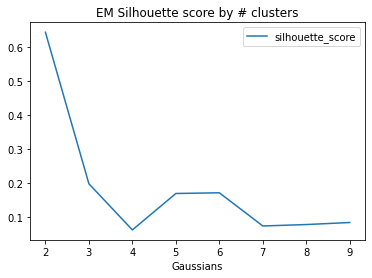

In [519]:
start= time.time()
em_l= get_k_em(10, l_data)
em_l.plot(x="Gaussians", y="silhouette_score", title="EM Silhouette score by # clusters")
plt.savefig("liver_num_gauss.png")
end= time.time()
print (end - start)

87.21716570854187


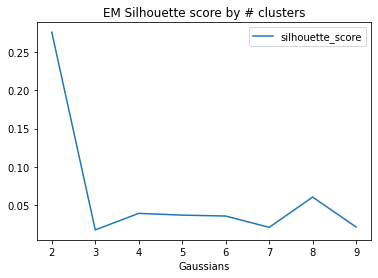

In [521]:
start= time.time()
em_c= get_k_em(10, c_data)
em_c.plot(x="Gaussians", y="silhouette_score", title="EM Silhouette score by # clusters")
plt.savefig("census_num_gauss.png")
end= time.time()
print (end - start)

## Number of clusters k means

0.38398027420043945


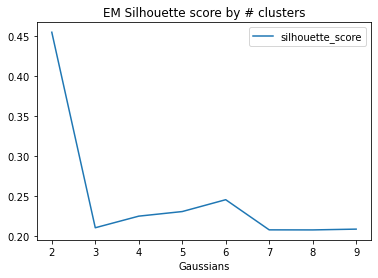

In [522]:
start= time.time()
em_l= get_k_km(10, l_data)
em_l.plot(x="Gaussians", y="silhouette_score", title="EM Silhouette score by # clusters")
plt.savefig("liver_num_km.png")
end= time.time()
print (end - start)



In [1160]:
KMeans?

0.9353079795837402


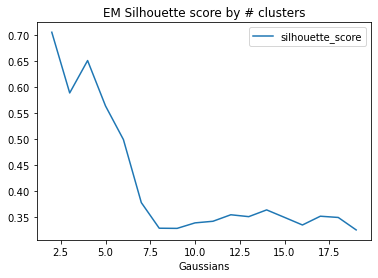

In [1159]:
start= time.time()
em_c= get_k_km(20, c_data)
em_c.plot(x="Gaussians", y="silhouette_score", title="EM Silhouette score by # clusters")
# plt.savefig("census_num_km.png")
end= time.time()
print (end - start)

# Dim red Liver clusters 

In [539]:
pca = PCA()
ica = FastICA()
lda = LinearDiscriminantAnalysis()
rp = random_projection.GaussianRandomProjection(n_components = 2 )

## Reduce Dimensions

In [1076]:
km = KMeans(n_clusters=2)
gm = GaussianMixture(n_components=2)

Liver (2280, 9)
(570, 9)
Liver (2280, 9)
(570, 9)
Liver (2280, 9)
(570, 9)
Liver (2280, 9)
(570, 9)
Liver (2280, 9)
(570, 9)
Liver (2280, 9)
(570, 9)
Liver (2280, 9)
(570, 9)
Liver (2280, 9)
(570, 9)
Liver (2280, 9)
(570, 9)
Census (130148, 40)
(32537, 40)
Census (130148, 40)
(32537, 40)
Census (130148, 40)
(32537, 40)
Census (130148, 40)
(32537, 40)
Census (130148, 40)
(32537, 40)
Census (130148, 40)
(32537, 40)
Census (130148, 40)
(32537, 40)
Census (130148, 40)
(32537, 40)
Census (130148, 40)
(32537, 40)


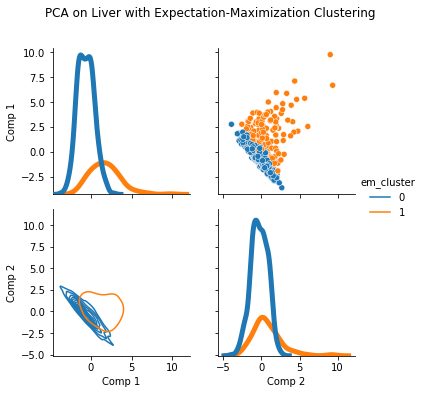

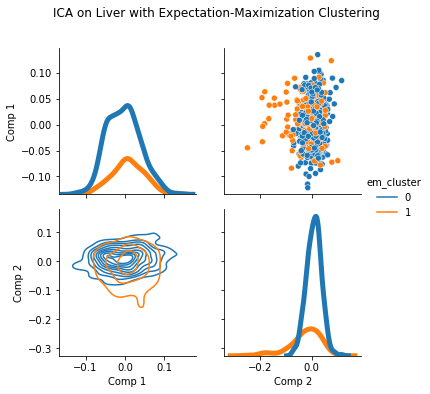

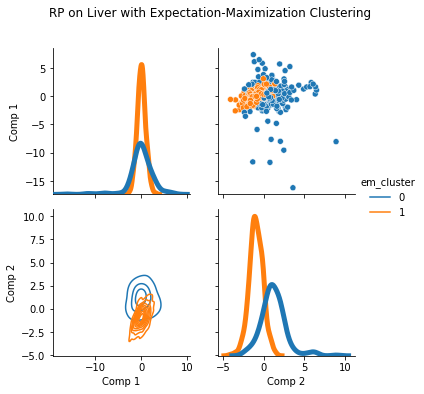

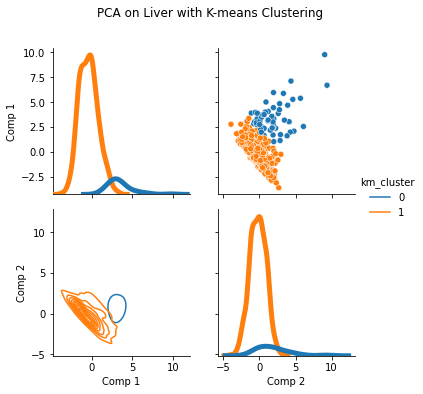

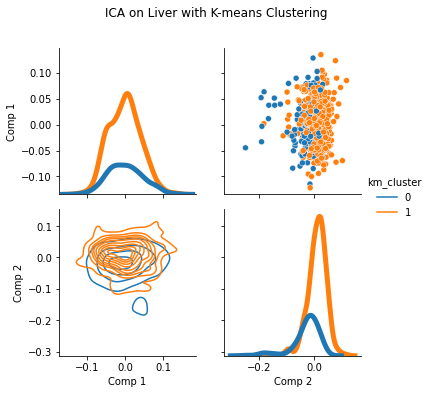

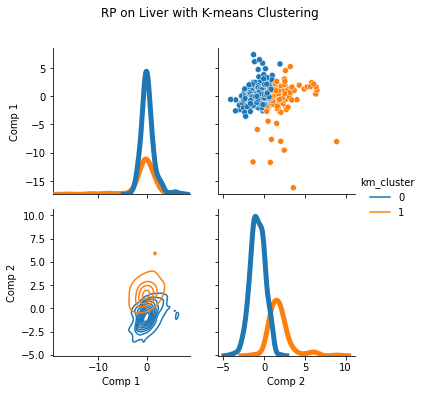

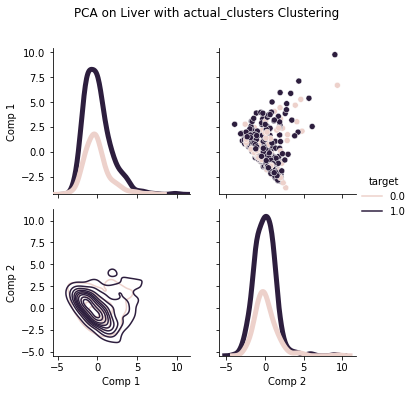

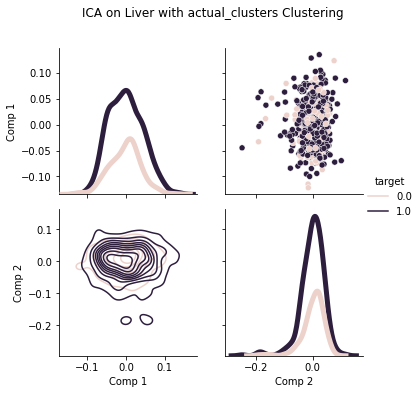

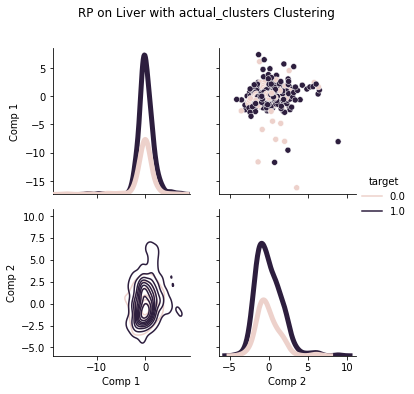

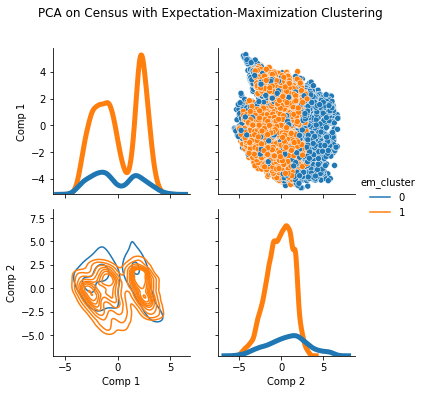

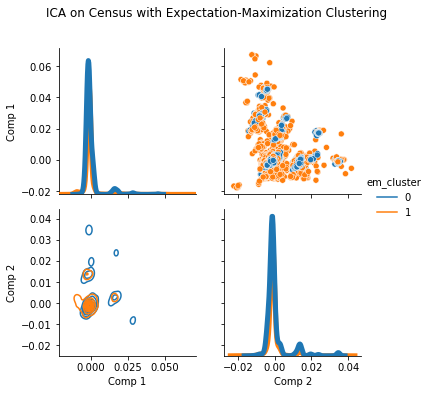

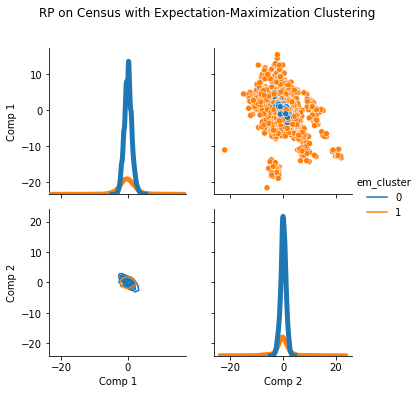

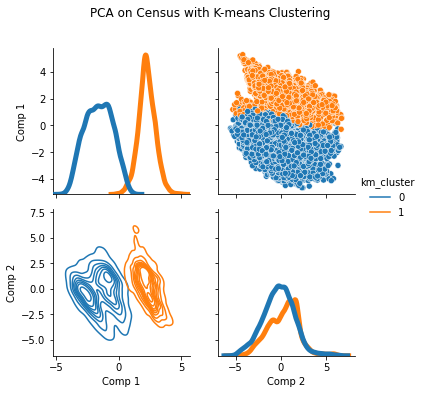

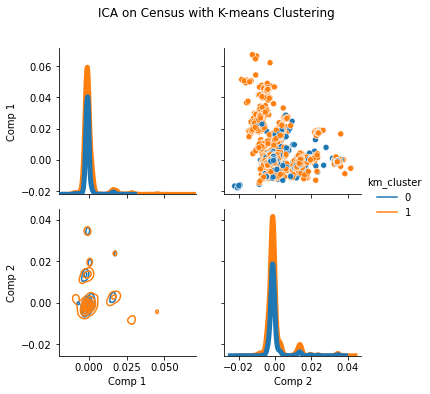

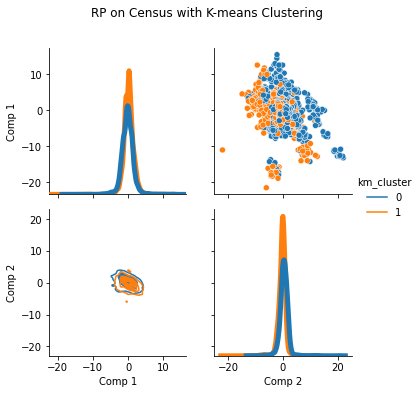

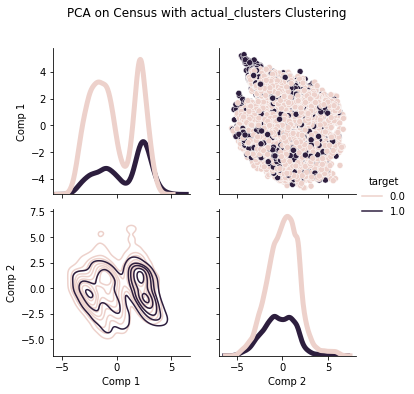

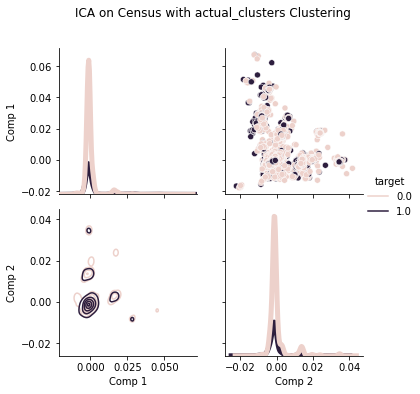

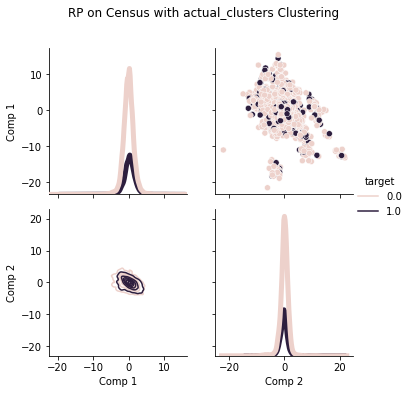

In [1080]:
for data in [(liver_clusters, "Liver"),(census_clusters, "Census")]:
    for cluster in [("em_cluster","Expectation-Maximization"),("km_cluster","K-means") ,("target","actual_clusters")]:
        for dim_type in ["PCA","ICA","RP"]:
   
            #create plots
            print(data[1], data[0].shape)
        
        
            create_lil_grid(dim_type, 
                            cluster[0], 
                            cluster[1],
                            data[1],
                            data[0],  
                             )

In [1077]:
c_data.shape

(32537, 108)

In [1144]:
liver_dim_red = apply_dimension_reduction(l_data.shape[1]//2,l_data, 2, y)
census_dim_red = apply_dimension_reduction(c_data.shape[1]//3,c_data, 2, y_c.income)

(570, 10)
(570, 10)
(32537, 108)
(32537, 108)


In [962]:
def dim_red_to_df(trans_, data, dim_type, rp_iter, y=None):
    
    if dim_type.lower() == "lda":
        dim_red_data = trans_.fit_transform(data, y)
        col_name = [f"Comp {i+1}" for i in range(dim_red_data.shape[1]) ]
        df = pd.DataFrame(dim_red_data, columns = col_name)
        df["dim_type"]= dim_type
        df["target"]=y
        return df , trans_
    
    elif dim_type.lower() == "rp":
        print(df.shape)
        df = iterate_rp(trans_, data, rp_iter)
        df["dim_type"]= dim_type
        df["target"]=y
        return df , trans_
        
    else:
        print(data.shape)
        dim_red_data = trans_.fit_transform(data)
        col_name = [f"Comp {i+1}" for i in range(dim_red_data.shape[1]) ]
        df = pd.DataFrame(dim_red_data, columns = col_name)
        df["dim_type"]= dim_type
        df["target"]=y
        return df , trans_
    
    
    
def apply_dimension_reduction(n_comp, data, rp_iter, y=None):
    pca = PCA(n_components=n_comp)
    ica = FastICA(n_components=n_comp,whiten=True,max_iter=500)
    lda = LinearDiscriminantAnalysis()
    rp = random_projection.GaussianRandomProjection( n_components=n_comp)
    
    
    pca_df, pca_t =  dim_red_to_df(pca, data, "PCA",rp_iter,y)
    ica_df, ica_t=dim_red_to_df(ica, data, "ICA",rp_iter,y)
    rp_df, rp_t=dim_red_to_df(rp, data, "RP",rp_iter,y)
    lda_df, lda_t=dim_red_to_df(lda, data, "LDA",rp_iter,y)
    
    df_to_stack=[pca_df , ica_df,rp_df, lda_df]
    
    return pd.concat(df_to_stack), pca_t , ica_t,rp_t, lda_t

# Create Clusters 

In [1145]:
liver_clusters = apply_clusters(liver_dim_red)
census_clusters = apply_clusters(census_dim_red)

In [1162]:
census_clusters = apply_clusters(census_dim_red)
census_clusters[census_clusters.dim_type=="ICA"]

,Comp 1,Comp 2,Comp 3,Comp 4,Comp 5,Comp 6,Comp 7,Comp 8,Comp 9,Comp 10,Comp 11,Comp 12,Comp 13,Comp 14,Comp 15,Comp 16,Comp 17,Comp 18,Comp 19,Comp 20,Comp 21,Comp 22,Comp 23,Comp 24,Comp 25,Comp 26,Comp 27,Comp 28,Comp 29,Comp 30,Comp 31,Comp 32,Comp 33,Comp 34,Comp 35,Comp 36,dim_type,target,em_cluster,km_cluster
0,0.001808,0.007744,-0.004120,-0.004430,0.003839,-0.000891,0.002791,-0.022555,-0.001837,-0.003546,0.000155,-0.000164,-0.001592,0.000356,-0.000175,0.018035,-0.002289,-0.018808,-0.001330,-0.001256,-8.377030e-04,0.007918,-0.000482,-0.000542,-0.000145,-0.000398,0.003264,-0.002548,0.000076,0.001629,-0.000444,0.000867,-0.002583,0.001894,0.059158,0.003693,ICA,0.0,0,1
1,0.005201,0.007436,-0.001437,-0.005108,0.004881,0.000873,0.002609,0.002754,-0.001821,0.011582,0.003143,0.012391,-0.002544,-0.003310,-0.002954,0.018422,-0.002416,-0.015859,-0.002761,-0.001313,-1.979158e-03,0.007335,-0.001755,-0.000234,0.000268,-0.002364,0.003023,-0.002412,0.003407,0.001698,-0.001709,0.000578,-0.003117,0.001258,0.058990,0.004834,ICA,0.0,0,0
2,0.000604,0.001346,-0.000358,0.010716,0.000220,-0.001470,-0.014909,-0.023176,-0.001795,-0.003499,-0.000041,0.001443,-0.001890,0.001983,0.000914,0.017669,-0.002747,-0.007713,-0.000759,-0.000840,-1.285222e-03,-0.007800,-0.000885,-0.001863,0.000249,0.000072,-0.007896,-0.002803,-0.000026,0.001475,0.000126,0.001158,-0.001442,0.002035,0.059394,0.002856,ICA,0.0,1,1
3,0.000062,0.001487,-0.001812,0.020562,0.002989,0.001287,0.002683,0.001184,-0.000529,0.000117,0.001708,0.000240,-0.002151,-0.000930,-0.000861,-0.000665,-0.002422,-0.003435,-0.001313,-0.000844,1.322593e-04,-0.001354,-0.000968,0.018572,-0.001857,0.020933,0.003808,-0.001748,0.000935,0.000721,-0.001525,0.001391,-0.003499,-0.002227,0.053228,0.002390,ICA,0.0,1,1
4,-0.016085,-0.007398,0.004388,-0.006047,0.004332,-0.000061,0.001685,0.001236,-0.003240,-0.002309,0.000484,0.008813,-0.003703,0.001078,0.001440,0.023741,-0.000440,0.000516,-0.002387,-0.001088,-3.834141e-04,-0.005870,-0.001808,0.000353,-0.002581,-0.000142,0.003026,-0.004434,-0.000931,0.001183,-0.000014,0.001011,-0.016173,0.002503,0.052739,0.001022,ICA,0.0,0,0
5,0.001334,0.000978,0.002521,0.019681,0.000612,0.000048,0.002819,0.000272,-0.001732,-0.002837,-0.017441,-0.000462,-0.002315,-0.000779,-0.000672,-0.000450,-0.001394,0.005193,-0.002005,-0.000551,-1.130383e-03,0.006937,-0.001765,-0.000788,-0.001483,-0.000723,0.003819,-0.002349,0.000872,0.000964,-0.000779,0.001108,-0.001915,0.000968,0.051290,0.003067,ICA,0.0,1,0
6,0.001017,-0.013140,-0.002660,0.007151,0.000798,0.003042,0.003465,0.002178,-0.000646,0.000970,0.001962,-0.002078,-0.000994,-0.002720,-0.001761,0.022635,-0.003910,0.008416,-0.002975,-0.000263,-1.911894e-03,-0.000751,-0.003347,0.018639,-0.002075,-0.002256,-0.008991,0.002610,-0.015812,0.001414,-0.001464,0.001095,0.010013,0.003747,0.051225,-0.001195,ICA,0.0,1,0
7,-0.010886,0.005330,-0.004050,0.002111,0.004850,0.001184,0.001649,0.000610,0.003228,0.008353,0.001104,0.000736,-0.000651,0.001175,-0.000605,-0.001892,-0.001377,-0.022415,-0.000629,0.032962,2.775491e-02,0.001898,-0.002666,-0.009326,-0.003347,0.000191,-0.003204,0.008164,0.002983,0.001846,-0.000011,0.000612,-0.007605,-0.000570,0.049672,-0.003990,ICA,1.0,0,0
8,-0.015177,0.007586,0.014032,0.004073,0.005939,-0.002165,0.000798,-0.000638,-0.003629,0.001856,-0.000620,0.006306,0.014230,0.000816,0.000426,-0.000407,-0.001777,-0.008608,0.000210,-0.000504,2.105174e-03,0.009922,0.000243,0.004071,-0.000854,0.000178,0.015397,-0.003989,-0.001899,0.001551,0.000131,0.000276,-0.004246,0.004309,0.049510,0.001964,ICA,0.0,0,1
9,0.001821,-0.005362,-0.008498,0.015262,0.008605,0.000824,0.001556,0.000223,-0.002166,-0.008397,0.000328,0.001231,-0.001334,0.016348,0.000439,-0.001881,0.020069,-0.007424,-0.002305,-0.001703,-8.833424e-04,-0.008094,-0.001360,-0.004058,0.000240,-0.000704,-0.013008,-0.002055,0.000038,0.000904,0.000316,0.000522,0.008291,0.002279,0.040491,0.002435,ICA,1.0,1,0


## Census plots 

In [502]:
# import seaborn as sns 
# g = sns.FacetGrid(census_clusters[~(census_clusters.dim_type=="LDA")], col="dim_type" , row="target",
#                   margin_titles=True,
#                   legend_out = True)
# g.map_dataframe(sns.scatterplot, "Comp 1", "Comp 2", color=".3", hue="km_cluster" ,x_jitter=.1 , alpha=.5)
# g.add_legend()

In [503]:
# import seaborn as sns 
# g = sns.FacetGrid(census_clusters[~(census_clusters.dim_type=="LDA")], col="dim_type" , row="target",
#                   margin_titles=True,
#                   legend_out = True)
# g.map_dataframe(sns.scatterplot, "Comp 1", "Comp 2", color=".3", hue="em_cluster" ,x_jitter=.1 , alpha=.5)
# g.add_legend()

## yo yo yo yo 

In [1201]:
c_data.shape

(500, 2)

In [1214]:
c_data_xxx = apply_dimension_reduction(c_data.shape[1],c_data, 1, y_c)
census_clusters = apply_clusters(c_data_xxx)




(32537, 108)
(32537, 108)


In [1211]:
sum(y.isna())

24

In [1215]:
x,y=get_model_data(census_clusters[census_clusters.dim_type=="RP"].dropna(), col_name, "RP")

rp_data = create_plot_get_data_numpy(x,y)
rp_data




,Training,Cross_Validation,epoch,fit_time,score_time
0,0.329585,0.329247,1,0.090292,0.004252
1,0.216775,0.217821,3,0.231901,0.004010
2,0.214268,0.214037,5,0.388260,0.004087
3,0.217267,0.217512,7,0.531366,0.004162
4,0.328532,0.328416,9,0.696744,0.004259
5,0.322565,0.322172,11,0.849945,0.004155
6,0.325641,0.325402,13,1.000975,0.004092
7,0.214107,0.213761,15,1.157717,0.003867
8,0.320351,0.321803,17,1.255546,0.003909
9,0.321869,0.322036,19,1.492876,0.004016


In [ ]:
# x,y=get_model_data(census_train_dim_red, ["em_cluster"], "RP")
# rp_data_em= create_plot_get_data_numpy(x,y)
# rp_data_em


# x,y=get_model_data(census_train_dim_red, ["km_cluster"], "RP")
# rp_data_km= create_plot_get_data_numpy(x,y)
# rp_data_km

# plot_lc("RP","ICA",ica_data)
# plot_lc("RP","K-means",ica_data_km)
# plot_lc("RP","RP",ica_data_em)

In [ ]:
census_clusters[census_clusters.dim_type=="RP"]

Census (130148, 112)
(32537, 112)
Census (130148, 112)
(32537, 112)
Census (130148, 112)
(32537, 112)


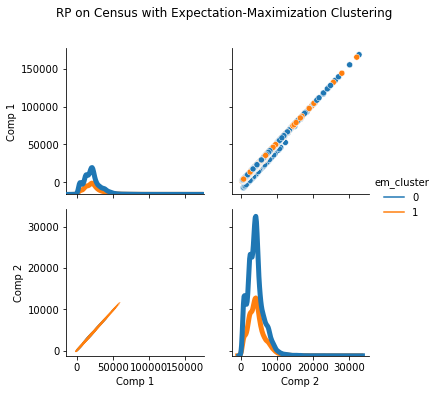

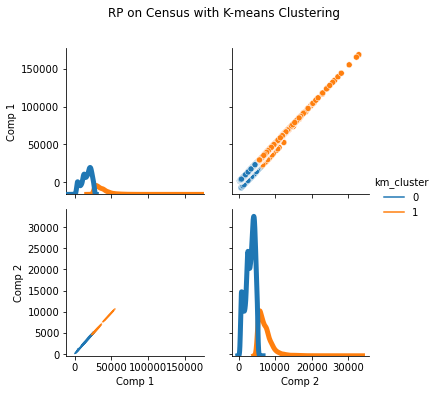

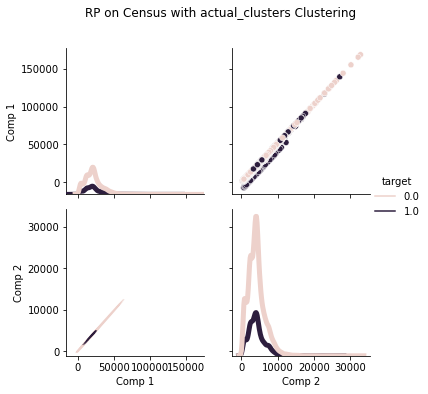

In [1204]:
for data in [(census_clusters, "Census")]:
    for cluster in [("em_cluster_1","Expectation-Maximization"),("km_cluster_1","K-means") ,("target_1","actual_clusters")]:
        for dim_type in ["RP"]:
   
            #create plots
            print(data[1], data[0].shape)
        
        
            create_lil_grid(dim_type, 
                            cluster[0], 
                            cluster[1],
                            data[1],
                            data[0],  
                             )

In [500]:
# g = sns.PairGrid(census_clusters[census_clusters.dim_type=="ICA"], vars=["Comp 1", "Comp 2"], hue="km_cluster")
# g.map_upper(sns.scatterplot)
# g.map_lower(sns.kdeplot)
# g.map_diag(sns.kdeplot, lw=5, legend=True)
# g.add_legend()
# g.fig.suptitle("Your Title", y=1.08) 
# fig = sns_plot.get_figure()
# fig.savefig("output.png")



# g = sns.PairGrid(census_clusters[census_clusters.dim_type=="ICA"], vars=["Comp 1", "Comp 2"], hue="target")
# g.map_upper(sns.scatterplot)
# g.map_lower(sns.kdeplot)
# g.map_diag(sns.kdeplot, lw=5, legend=True)
# g.add_legend()



## Lda 

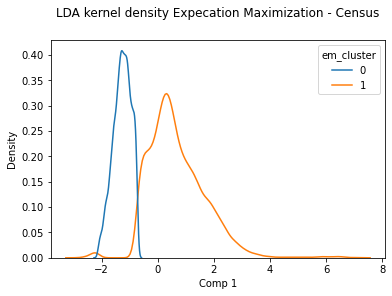

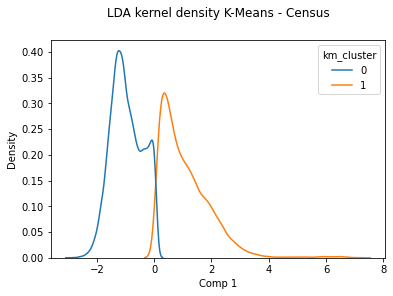

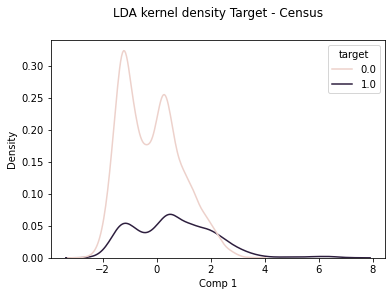

<Figure size 432x288 with 0 Axes>

In [595]:
ax= sns.kdeplot(data=census_clusters[census_clusters.dim_type=="LDA"], x="Comp 1", hue="em_cluster")
ax.set_title("LDA kernel density Expecation Maximization - Census", y=1.08);
plt.savefig("census_lda_kde_em.png")
plt.show()
plt.clf()

ax= sns.kdeplot(data=census_clusters[census_clusters.dim_type=="LDA"], x="Comp 1", hue="km_cluster")
ax.set_title("LDA kernel density K-Means - Census", y=1.08);
plt.savefig("census_lda_kde_km.png")
plt.show()
plt.clf()

ax= sns.kdeplot(data=census_clusters[census_clusters.dim_type=="LDA"], x="Comp 1", hue="target")
ax.set_title("LDA kernel density Target - Census", y=1.08);
plt.savefig("census_lda_kde_target.png")
plt.show()
plt.clf()




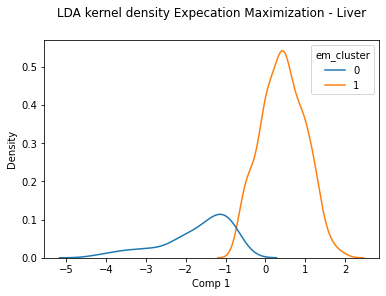

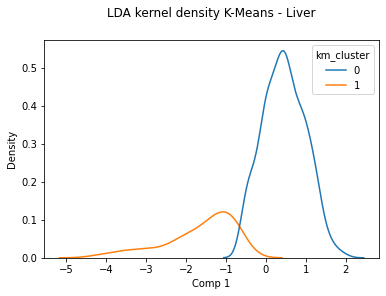

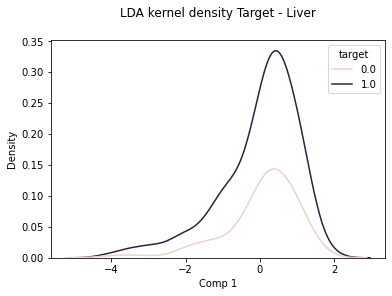

<Figure size 432x288 with 0 Axes>

In [596]:

ax= sns.kdeplot(data=liver_clusters[liver_clusters.dim_type=="LDA"], x="Comp 1", hue="em_cluster")
ax.set_title("LDA kernel density Expecation Maximization - Liver", y=1.08);
plt.savefig("liver_clusters_lda_kde_em.png")
plt.show()
plt.clf()

ax= sns.kdeplot(data=liver_clusters[liver_clusters.dim_type=="LDA"], x="Comp 1", hue="km_cluster")
ax.set_title("LDA kernel density K-Means - Liver", y=1.08);
plt.savefig("liver_clusters_lda_kde_km.png")
plt.show()
plt.clf()

ax= sns.kdeplot(data=liver_clusters[liver_clusters.dim_type=="LDA"], x="Comp 1", hue="target")
ax.set_title("LDA kernel density Target - Liver", y=1.08);
plt.savefig("liver_clusters_lda_kde_target.png")
plt.show()
plt.clf()


# Modeling 

In [ ]:
km = KMeans(n_clusters=2)
gm = GaussianMixture(n_components=2)

In [604]:
def get_census_pipeline_final(iter_=19):
    liver_steps = [('encoding', OneHotEncoder(cols=categorical_columns)),
         ('imputer',SimpleImputer(missing_values=np.NaN, strategy='most_frequent')),
         ('scaler', StandardScaler()),
                   ("model",   MLPClassifier( max_iter=iter_ ,
                                             solver ="adam",
                                             activation="relu",
                                             alpha=0.42858571428571435,
                                             learning_rate="invscaling",
                                             random_state = 12, 
                                             ))]
    return Pipeline(steps=liver_steps)




train_data, test_data = train_test_split(census_df,
                                         test_size=0.2,
                                         stratify=census_df['income'],
                                         random_state=65)
print('Train data shape is {}'.format(train_data.shape))
print('Test data shape is {}'.format(test_data.shape))
X_c_train = train_data.drop('income', axis=1)
y_c_train = train_data['income']
X_c_test= test_data.drop('income', axis=1)
y_c_test= test_data['income']

Train data shape is (26029, 15)
Test data shape is (6508, 15)


## Base nn 

In [725]:

import warnings
warnings.filterwarnings("ignore")

In [777]:
scores

{'fit_time': array([13.92425895, 13.66574836, 13.77758026, 13.68903399, 14.16172266]),
 'score_time': array([0.03413486, 0.03220272, 0.03220725, 0.03440785, 0.03373361]),
 'test_score': array([0.83864771, 0.83230887, 0.83864771, 0.83442182, 0.82997118]),
 'train_score': array([0.9155261 , 0.91226048, 0.91643855, 0.91528598, 0.91524203])}

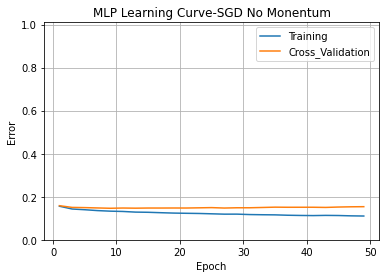

In [893]:

def get_census_pipeline(iter_=1):
    liver_steps = [('encoding', OneHotEncoder(cols=categorical_columns)),
         ('imputer',SimpleImputer(missing_values=np.NaN, strategy='most_frequent')),
         ('scaler', StandardScaler()),
                   ("model",   MLPClassifier( max_iter=iter_ , solver ="adam"
                                             ))]
    return Pipeline(steps=liver_steps)



stratified_kfold = StratifiedKFold(n_splits = 5, random_state=42, shuffle=True)
val_train_scores = []
for i in range (1,50,2):
    scores = cross_validate(get_census_pipeline(i), X_c_train, y_c_train, cv=stratified_kfold,
                   scoring=('accuracy'),
                    return_train_score=True)
    val = 1. - scores['test_score'].mean()
    training = 1. - scores['train_score'].mean()
    epoch = i
    val_train_scores.append([training,val,epoch])
    
pd_val_base = pd.DataFrame(val_train_scores, columns=["Training", "Cross_Validation","epoch"])
val_plot =pd_val_base.plot(y=["Training", "Cross_Validation"],x="epoch", title="MLP Learning Curve-SGD No Monentum" )
plt.ylim(0.0, 1.01)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.grid()
plt.savefig("MLP_BASE_CENSUS_LEARNING_CURVE_SGD.pdf")

## Base data nn

In [1064]:
base_data = create_plot_get_data(X_c_train,y_c_train)

In [1065]:
base_data

,Training,Cross_Validation,epoch,fit_time,score_time
0,0.155461,0.159322,1,0.343720,0.037807
1,0.144377,0.151216,3,0.520942,0.037957
2,0.139623,0.149794,5,0.707171,0.037847
3,0.135522,0.148565,7,0.801365,0.033721
4,0.133169,0.147259,9,0.899627,0.031068
5,0.131296,0.146798,11,1.040005,0.030965
6,0.129173,0.146414,13,1.181358,0.030883
7,0.126628,0.148219,15,1.360530,0.031713
8,0.126081,0.147413,17,1.519838,0.031956
9,0.125331,0.147912,19,1.659073,0.031712


In [921]:
def plot_lc(name, dim_red_type,df):
    val_plot =df.plot(y=["Training", "Cross_Validation"],x="epoch", title=f"{name}  Learning Curve with {dim_red_type} Reduction" )
    plt.ylim(0.0, 1.01)
    plt.ylabel('Error')
    plt.xlabel('Epoch')
    plt.grid()
    plt.savefig(f"{name}_{dim_red_type}_LEARNING_CURVE.png")
    plt.show()
    plt.clf()

     
        
    

### Census

### Reduce by 85%

In [896]:
pca_census_pipeline = Pipeline(pca_census_steps)
pca_census_pipeline.fit(X_c_train)
pca_census_pipeline
c_data_train = pca_census_pipeline.transform(X_c_train)
census_train_dim_red = apply_dimension_reduction(int((c_data_train.shape[1]*.85)//1),c_data_train, 3, y_c_train)

(26029, 108)
(26029, 108)


### add clusters

In [1151]:
census_train_dim_red_w_cluster = apply_clusters(census_train_dim_red)
lda_train = census_train_dim_red[["Comp 1", "em_cluster", "km_cluster","target"]][census_train_dim_red.dim_type=="LDA"].dropna()
lda_train.target = lda_train.target.map({">50K":1,"<=50K":0})
lda_x = lda_train[lda_train.columns[0]].to_numpy().reshape(-1,1)
lda_y = lda_train['target']

## lda Data

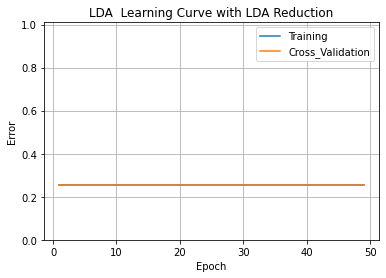

<Figure size 432x288 with 0 Axes>

In [922]:
lda_data = create_plot_get_data_numpy(lda_x,lda_y)
lda_data
plot_lc('LDA', "LDA" , lda_data)

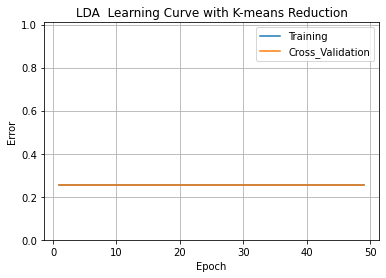

<Figure size 432x288 with 0 Axes>

In [923]:
lda_data_km = create_plot_get_data_numpy(lda_train['km_cluster'].to_numpy().reshape(-1,1),lda_y)
lda_data_km
plot_lc('LDA', "K-means" , lda_data_km)

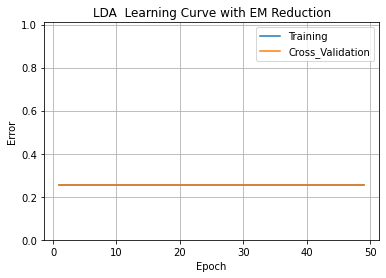

<Figure size 432x288 with 0 Axes>

In [924]:
lda_data_em = create_plot_get_data_numpy(lda_train['em_cluster'].to_numpy().reshape(-1,1),lda_y)
lda_data_em
plot_lc('LDA', "EM" , lda_data_em)

## PCA

In [936]:
census_train_dim_red

,Comp 1,Comp 2,Comp 3,Comp 4,Comp 5,Comp 6,Comp 7,Comp 8,Comp 9,Comp 10,Comp 11,Comp 12,Comp 13,Comp 14,Comp 15,Comp 16,Comp 17,Comp 18,Comp 19,Comp 20,Comp 21,Comp 22,Comp 23,Comp 24,Comp 25,Comp 26,Comp 27,Comp 28,Comp 29,Comp 30,Comp 31,Comp 32,Comp 33,Comp 34,Comp 35,Comp 36,Comp 37,Comp 38,Comp 39,Comp 40,Comp 41,Comp 42,Comp 43,Comp 44,Comp 45,Comp 46,Comp 47,Comp 48,Comp 49,Comp 50,Comp 51,Comp 52,Comp 53,Comp 54,Comp 55,Comp 56,Comp 57,Comp 58,Comp 59,Comp 60,Comp 61,Comp 62,Comp 63,Comp 64,Comp 65,Comp 66,Comp 67,Comp 68,Comp 69,Comp 70,Comp 71,Comp 72,Comp 73,Comp 74,Comp 75,Comp 76,Comp 77,Comp 78,Comp 79,Comp 80,Comp 81,Comp 82,Comp 83,Comp 84,Comp 85,Comp 86,Comp 87,Comp 88,Comp 89,Comp 90,Comp 91,dim_type,target,em_cluster,km_cluster
0,-0.570983,0.950413,-0.768851,-0.030579,-2.065594,-0.359129,-1.502917,-0.883901,-0.818698,-0.479954,-0.683553,-0.517616,1.394593,-2.299954,-1.023989,1.427491,-0.540227,0.194723,1.313148,-0.157744,-0.797616,0.958519,-0.158386,0.527904,0.414784,0.144370,0.171732,0.224700,-1.109557,-0.664607,0.391058,-0.308591,-1.153055,0.189689,-0.673827,-1.554837,-0.553250,0.312524,-0.589566,1.274845,0.807571,-0.014251,0.605980,-0.406338,0.269089,0.057226,-0.107009,-0.062946,0.042671,0.015097,-0.086457,-0.010899,-0.009012,0.282243,0.138618,0.078633,0.271935,-0.153172,0.027933,0.344198,-0.308859,-0.134954,0.550972,1.211189,0.452956,0.026195,-0.845417,-0.750828,0.123491,-0.387564,-0.318851,0.281174,1.596529,0.327267,0.379566,0.878715,0.426121,0.761931,0.407696,0.162460,0.557357,-0.464043,0.218009,-0.629484,0.407198,0.523253,-0.447496,0.189536,1.374358,0.622837,0.297568,PCA,<=50K,0,0
1,-3.236205,-1.211927,-1.231127,-0.126288,1.841863,-0.316177,1.229156,1.888958,2.893234,0.920376,-1.304572,-0.446118,1.040541,0.132450,0.093500,0.118828,1.986850,0.820300,0.562388,-1.542288,0.015125,-0.648098,1.409365,-0.546931,-0.857641,-0.167594,-0.301686,0.542587,-0.358841,1.008289,-0.626951,0.419194,-0.702370,0.695475,-0.384660,0.037687,-0.283836,0.698729,0.813926,-0.268144,-0.021202,-0.569043,-0.602877,-0.079289,-0.427489,-0.094701,0.015582,-0.015298,-0.259410,0.075248,0.345978,0.244630,-0.035549,-0.185375,0.062050,0.215060,-0.065674,-0.234709,-0.643527,0.377586,0.049281,0.191553,0.278871,-0.579463,-0.096712,0.528311,0.277222,-0.420305,0.003907,0.292583,0.071709,-0.042137,-0.655555,-0.339175,-0.548059,0.180024,1.124336,0.902799,-0.271375,-1.097886,-0.168568,-0.265734,1.038909,0.388454,0.360299,-0.211505,0.909112,-0.372235,-0.019793,-0.132799,-0.819754,PCA,NaN,0,0
2,-1.958093,-0.579507,-0.379268,1.576918,-2.427543,0.888424,0.196661,-1.947201,-0.491594,-1.018493,1.173897,-0.073772,-2.005597,0.250941,0.831508,-0.962567,1.946977,-3.096553,-0.294570,-1.283265,0.828436,-0.801498,-0.214738,1.265975,0.423920,-0.814653,-1.091001,-0.115851,-0.251193,-0.799869,-0.652872,0.550506,0.351368,0.198482,-1.090284,-0.571638,-0.702794,0.465505,-0.305550,-0.668579,0.021618,0.079199,0.065495,0.452310,0.024323,-0.443670,0.309008,0.099973,-0.028900,-0.169579,0.211493,-0.172185,-0.155287,-0.143350,0.198961,-0.276902,-0.298882,0.271888,-0.272441,-0.602045,0.170429,-0.345064,-0.120815,-0.056076,0.465103,0.113982,-0.243193,-0.337667,0.787322,-0.332970,0.204861,0.143278,-0.582562,0.674347,0.186369,-0.226274,-0.154422,0.449203,0.134745,-0.289219,-0.260093,0.627356,1.087302,-0.673549,0.765852,0.547966,-0.930029,-0.255424,-0.200719,-0.651931,-0.931597,PCA,<=50K,0,0
3,-4.189257,1.443315,-0.173083,-0.884195,1.557550,-2.573696,1.187006,1.469930,-0.706659,-0.021699,2.645221,-1.246256,-0.841562,-0.444335,0.341088,-0.266582,-0.426160,-1.041002,0.387799,-0.406861,-0.522427,0.929770,0.403863,1.601644,0.510681,1.095990,-0.588427,0.420448,-0.256343,-0.440102,-1.872003,0.023082,-0.547330,1.753708,1.474925,0.038153,0.083726,-0.136336,-0.376259,-0.874362,-0.560090,0.690948,-0.319959,0.437027,-0.176865,-0.524697,0.350622,-0.083436,0.194958,-0.123582,0.027892,-0.442070,0.199975,0.021079,0.359331,-0.294079,-0.218801,-0.076974,-0.050519,0.137699,0.635898,0.535384,-0.

In [937]:
census_train_dim_red = apply_dimension_reduction(int((c_data_train.shape[1]*.85)//1),c_data_train, 2, y_c_train)
census_train_dim_red_w_cluster = apply_clusters(census_train_dim_red)
census_train_dim_red.dropna(inplace=True)
census_train_dim_red.target = census_train_dim_red.target.map({">50K":1,"<=50K":0}).dropna(inplace=True)

(26029, 108)
(26029, 108)


In [1186]:
pca_data

,Training,Cross_Validation,epoch,fit_time,score_time,cumualtive_runtime,dim_type,cumulative_runtime
0,0.254165,0.256469,1,0.066473,0.004438,0.066473,PCA,0.066473
1,0.252545,0.256565,3,0.177314,0.004353,0.243786,PCA,0.243786
2,0.251980,0.255509,5,0.286168,0.004316,0.529954,PCA,0.529954
3,0.251236,0.256469,7,0.394881,0.004311,0.924836,PCA,0.924836
4,0.250900,0.256853,9,0.507047,0.004318,1.431882,PCA,1.431882
5,0.249532,0.257862,11,0.620434,0.004339,2.052316,PCA,2.052316
6,0.248272,0.257622,13,0.733944,0.004325,2.786260,PCA,2.786260
7,0.247407,0.259446,15,0.837764,0.004179,3.624024,PCA,3.624024
8,0.246471,0.259734,17,0.950149,0.004178,4.574173,PCA,4.574173
9,0.245355,0.260839,19,1.066589,0.004282,5.640762,PCA,5.640762


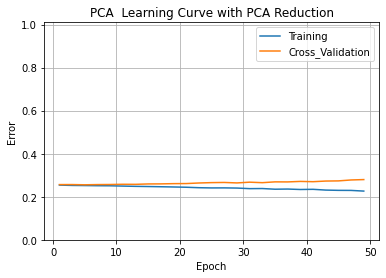

<Figure size 432x288 with 0 Axes>

In [925]:

col_name = col_name = [c for c in census_train_dim_red.columns if "Comp" in c ]


x,y=get_model_data(census_train_dim_red, col_name, "PCA")

pca_data = create_plot_get_data_numpy(x,y)
pca_data
plot_lc('PCA', "PCA" , pca_data)


In [887]:


x,y=get_model_data(census_train_dim_red, ["km_cluster"], "PCA")
pca_data_km = create_plot_get_data_numpy(x,y)
pca_data_km



,Training,Cross_Validation,epoch,fit_time,score_time
0,0.253781,0.253781,1,0.042014,0.003236
1,0.253781,0.253781,3,0.119449,0.003304
2,0.253781,0.253781,5,0.166836,0.002773
3,0.253781,0.253781,7,0.223920,0.002679
4,0.253781,0.253781,9,0.285522,0.002673
5,0.253781,0.253781,11,0.345649,0.002815
6,0.253781,0.253781,13,0.410755,0.002667
7,0.253781,0.253781,15,0.455506,0.002703
8,0.253781,0.253781,17,0.498266,0.002670
9,0.253781,0.253781,19,0.465242,0.002672


In [888]:

x,y=get_model_data(census_train_dim_red, ["em_cluster"], "PCA")
pca_data_em = create_plot_get_data_numpy(x,y)
pca_data_em



,Training,Cross_Validation,epoch,fit_time,score_time
0,0.253781,0.253781,1,0.035103,0.002642
1,0.253781,0.253781,3,0.097040,0.002606
2,0.253781,0.253781,5,0.159920,0.002659
3,0.253781,0.253781,7,0.223241,0.002672
4,0.253781,0.253781,9,0.297273,0.002977
5,0.253781,0.253781,11,0.360307,0.002698
6,0.253781,0.253781,13,0.415397,0.002794
7,0.253781,0.253781,15,0.480883,0.002918
8,0.253781,0.253781,17,0.495803,0.002678
9,0.253781,0.253781,19,0.478587,0.002690


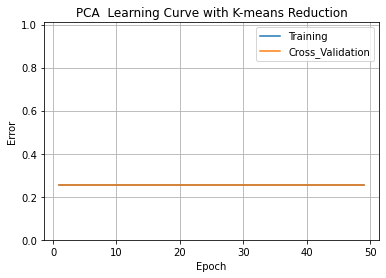

<Figure size 432x288 with 0 Axes>

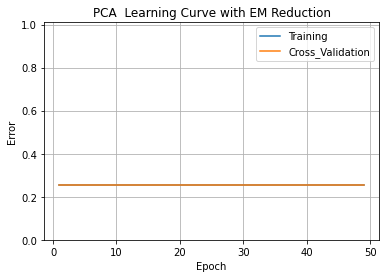

<Figure size 432x288 with 0 Axes>

In [926]:
plot_lc('PCA', "K-means" , pca_data_km)
plot_lc('PCA', "EM" , pca_data_em)


# ICA 

In [929]:
sum(y)/len(y)

0.25378078640357193

In [1163]:
census_clusters[census_clusters.dim_type=="ICA"]

,Comp 1,Comp 2,Comp 3,Comp 4,Comp 5,Comp 6,Comp 7,Comp 8,Comp 9,Comp 10,Comp 11,Comp 12,Comp 13,Comp 14,Comp 15,Comp 16,Comp 17,Comp 18,Comp 19,Comp 20,Comp 21,Comp 22,Comp 23,Comp 24,Comp 25,Comp 26,Comp 27,Comp 28,Comp 29,Comp 30,Comp 31,Comp 32,Comp 33,Comp 34,Comp 35,Comp 36,dim_type,target,em_cluster,km_cluster
0,0.001808,0.007744,-0.004120,-0.004430,0.003839,-0.000891,0.002791,-0.022555,-0.001837,-0.003546,0.000155,-0.000164,-0.001592,0.000356,-0.000175,0.018035,-0.002289,-0.018808,-0.001330,-0.001256,-8.377030e-04,0.007918,-0.000482,-0.000542,-0.000145,-0.000398,0.003264,-0.002548,0.000076,0.001629,-0.000444,0.000867,-0.002583,0.001894,0.059158,0.003693,ICA,0.0,0,1
1,0.005201,0.007436,-0.001437,-0.005108,0.004881,0.000873,0.002609,0.002754,-0.001821,0.011582,0.003143,0.012391,-0.002544,-0.003310,-0.002954,0.018422,-0.002416,-0.015859,-0.002761,-0.001313,-1.979158e-03,0.007335,-0.001755,-0.000234,0.000268,-0.002364,0.003023,-0.002412,0.003407,0.001698,-0.001709,0.000578,-0.003117,0.001258,0.058990,0.004834,ICA,0.0,0,0
2,0.000604,0.001346,-0.000358,0.010716,0.000220,-0.001470,-0.014909,-0.023176,-0.001795,-0.003499,-0.000041,0.001443,-0.001890,0.001983,0.000914,0.017669,-0.002747,-0.007713,-0.000759,-0.000840,-1.285222e-03,-0.007800,-0.000885,-0.001863,0.000249,0.000072,-0.007896,-0.002803,-0.000026,0.001475,0.000126,0.001158,-0.001442,0.002035,0.059394,0.002856,ICA,0.0,1,1
3,0.000062,0.001487,-0.001812,0.020562,0.002989,0.001287,0.002683,0.001184,-0.000529,0.000117,0.001708,0.000240,-0.002151,-0.000930,-0.000861,-0.000665,-0.002422,-0.003435,-0.001313,-0.000844,1.322593e-04,-0.001354,-0.000968,0.018572,-0.001857,0.020933,0.003808,-0.001748,0.000935,0.000721,-0.001525,0.001391,-0.003499,-0.002227,0.053228,0.002390,ICA,0.0,1,1
4,-0.016085,-0.007398,0.004388,-0.006047,0.004332,-0.000061,0.001685,0.001236,-0.003240,-0.002309,0.000484,0.008813,-0.003703,0.001078,0.001440,0.023741,-0.000440,0.000516,-0.002387,-0.001088,-3.834141e-04,-0.005870,-0.001808,0.000353,-0.002581,-0.000142,0.003026,-0.004434,-0.000931,0.001183,-0.000014,0.001011,-0.016173,0.002503,0.052739,0.001022,ICA,0.0,0,0
5,0.001334,0.000978,0.002521,0.019681,0.000612,0.000048,0.002819,0.000272,-0.001732,-0.002837,-0.017441,-0.000462,-0.002315,-0.000779,-0.000672,-0.000450,-0.001394,0.005193,-0.002005,-0.000551,-1.130383e-03,0.006937,-0.001765,-0.000788,-0.001483,-0.000723,0.003819,-0.002349,0.000872,0.000964,-0.000779,0.001108,-0.001915,0.000968,0.051290,0.003067,ICA,0.0,1,0
6,0.001017,-0.013140,-0.002660,0.007151,0.000798,0.003042,0.003465,0.002178,-0.000646,0.000970,0.001962,-0.002078,-0.000994,-0.002720,-0.001761,0.022635,-0.003910,0.008416,-0.002975,-0.000263,-1.911894e-03,-0.000751,-0.003347,0.018639,-0.002075,-0.002256,-0.008991,0.002610,-0.015812,0.001414,-0.001464,0.001095,0.010013,0.003747,0.051225,-0.001195,ICA,0.0,1,0
7,-0.010886,0.005330,-0.004050,0.002111,0.004850,0.001184,0.001649,0.000610,0.003228,0.008353,0.001104,0.000736,-0.000651,0.001175,-0.000605,-0.001892,-0.001377,-0.022415,-0.000629,0.032962,2.775491e-02,0.001898,-0.002666,-0.009326,-0.003347,0.000191,-0.003204,0.008164,0.002983,0.001846,-0.000011,0.000612,-0.007605,-0.000570,0.049672,-0.003990,ICA,1.0,0,0
8,-0.015177,0.007586,0.014032,0.004073,0.005939,-0.002165,0.000798,-0.000638,-0.003629,0.001856,-0.000620,0.006306,0.014230,0.000816,0.000426,-0.000407,-0.001777,-0.008608,0.000210,-0.000504,2.105174e-03,0.009922,0.000243,0.004071,-0.000854,0.000178,0.015397,-0.003989,-0.001899,0.001551,0.000131,0.000276,-0.004246,0.004309,0.049510,0.001964,ICA,0.0,0,1
9,0.001821,-0.005362,-0.008498,0.015262,0.008605,0.000824,0.001556,0.000223,-0.002166,-0.008397,0.000328,0.001231,-0.001334,0.016348,0.000439,-0.001881,0.020069,-0.007424,-0.002305,-0.001703,-8.833424e-04,-0.008094,-0.001360,-0.004058,0.000240,-0.000704,-0.013008,-0.002055,0.000038,0.000904,0.000316,0.000522,0.008291,0.002279,0.040491,0.002435,ICA,1.0,1,0


In [1167]:
cls = [c for c in census_clusters.columns if "Comp" in c ]

In [1169]:
x,y=get_model_data(census_clusters[census_clusters.dim_type=="ICA"].dropna(), cls, "ICA")
ica_data = create_plot_get_data_numpy(mms.fit_transform(x),y)
ica_data


,Training,Cross_Validation,epoch,fit_time,score_time
0,0.240950,0.240950,1,0.066856,0.002985
1,0.216344,0.216344,3,0.181135,0.002582
2,0.210078,0.210470,5,0.297099,0.002436
3,0.207025,0.207548,7,0.408898,0.002523
4,0.196206,0.195491,9,0.523255,0.002504
5,0.189501,0.189985,11,0.640121,0.002593
6,0.190347,0.190508,13,0.767316,0.002758
7,0.184057,0.184788,15,0.864432,0.002600
8,0.184242,0.184203,17,0.999120,0.002783
9,0.185349,0.185433,19,1.112582,0.002860


In [1170]:

x,y=get_model_data(census_clusters[census_clusters.dim_type=="ICA"].dropna(), ["em_cluster"], "ICA")
ica_data_em = create_plot_get_data_numpy(x,y)
ica_data_em

,Training,Cross_Validation,epoch,fit_time,score_time
0,0.24095,0.24095,1,0.052433,0.003488
1,0.24095,0.24095,3,0.153800,0.003536
2,0.24095,0.24095,5,0.240939,0.003541
3,0.24095,0.24095,7,0.339164,0.003512
4,0.24095,0.24095,9,0.430287,0.003519
5,0.24095,0.24095,11,0.521895,0.003502
6,0.24095,0.24095,13,0.623261,0.003529
7,0.24095,0.24095,15,0.670295,0.003525
8,0.24095,0.24095,17,0.661220,0.003567
9,0.24095,0.24095,19,0.657124,0.003505


In [1171]:

x,y=get_model_data(census_clusters[census_clusters.dim_type=="ICA"].dropna(), ["km_cluster"], "ICA")
ica_data_km = create_plot_get_data_numpy(x,y)
ica_data_km

,Training,Cross_Validation,epoch,fit_time,score_time
0,0.24095,0.24095,1,0.058059,0.003805
1,0.24095,0.24095,3,0.154225,0.003700
2,0.24095,0.24095,5,0.372037,0.005581
3,0.24095,0.24095,7,0.557341,0.005426
4,0.24095,0.24095,9,0.714654,0.005374
5,0.24095,0.24095,11,0.869932,0.005348
6,0.24095,0.24095,13,0.766884,0.004079
7,0.24095,0.24095,15,0.707857,0.003698
8,0.24095,0.24095,17,0.688226,0.003895
9,0.24095,0.24095,19,0.718679,0.003706


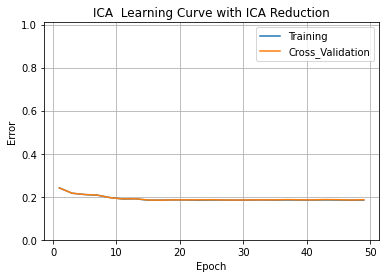

<Figure size 432x288 with 0 Axes>

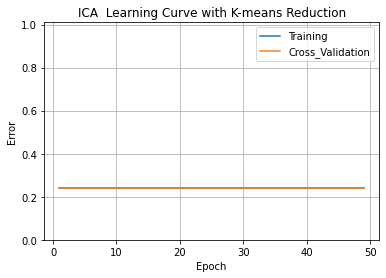

<Figure size 432x288 with 0 Axes>

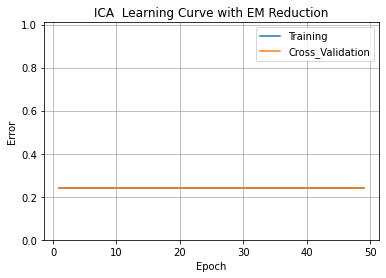

<Figure size 432x288 with 0 Axes>

In [1172]:
plot_lc("ICA","ICA",ica_data)
plot_lc("ICA","K-means",ica_data_km)
plot_lc("ICA","EM",ica_data_em)

## RP 

In [943]:
x,y=get_model_data(census_train_dim_red, col_name, "RP")

rp_data = create_plot_get_data_numpy(mms.fit_transform(x),y)
rp_data


x,y=get_model_data(census_train_dim_red, ["em_cluster"], "RP")
rp_data_em= create_plot_get_data_numpy(x,y)
rp_data_em


x,y=get_model_data(census_train_dim_red, ["em_cluster"], "RP")
rp_data_em= create_plot_get_data_numpy(x,y)
rp_data_em

,Training,Cross_Validation,epoch,fit_time,score_time
0,0.253781,0.253781,1,0.061694,0.002115
1,0.253781,0.253781,3,0.167554,0.002155
2,0.253781,0.253781,5,0.272968,0.002152
3,0.253781,0.253781,7,0.380164,0.002144
4,0.253781,0.253781,9,0.382228,0.001698
5,0.253781,0.253781,11,0.471386,0.001703
6,0.253781,0.253781,13,0.557684,0.001728
7,0.253781,0.253781,15,0.642067,0.001723
8,0.253781,0.253781,17,0.705610,0.001694
9,0.253781,0.253781,19,0.797012,0.001719


In [946]:

x,y=get_model_data(census_train_dim_red, ["em_cluster"], "RP")
rp_data_em= create_plot_get_data_numpy(x,y)
rp_data_em

,Training,Cross_Validation,epoch,fit_time,score_time
0,0.253781,0.253781,1,0.041622,0.003268
1,0.253781,0.253781,3,0.118890,0.003333
2,0.253781,0.253781,5,0.196572,0.003351
3,0.253781,0.253781,7,0.275166,0.003335
4,0.253781,0.253781,9,0.314594,0.002925
5,0.253781,0.253781,11,0.345072,0.002644
6,0.253781,0.253781,13,0.402144,0.002650
7,0.253781,0.253781,15,0.457375,0.002650
8,0.253781,0.253781,17,0.471831,0.002657
9,0.253781,0.253781,19,0.509110,0.002706


In [947]:

x,y=get_model_data(census_train_dim_red, ["km_cluster"], "RP")
rp_data_km = create_plot_get_data_numpy(x,y)
rp_data_km

,Training,Cross_Validation,epoch,fit_time,score_time
0,0.253781,0.253781,1,0.038852,0.003173
1,0.253781,0.253781,3,0.101623,0.002768
2,0.253781,0.253781,5,0.168020,0.003120
3,0.253781,0.253781,7,0.243145,0.002909
4,0.253781,0.253781,9,0.307063,0.002783
5,0.253781,0.253781,11,0.316383,0.002847
6,0.253781,0.253781,13,0.354871,0.002877
7,0.253781,0.253781,15,0.488132,0.002807
8,0.253781,0.253781,17,0.430841,0.002790
9,0.253781,0.253781,19,0.489806,0.002726


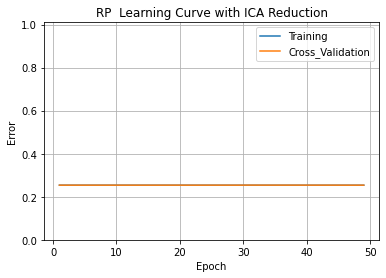

<Figure size 432x288 with 0 Axes>

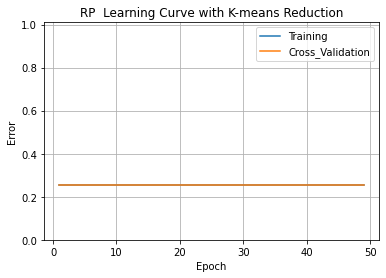

<Figure size 432x288 with 0 Axes>

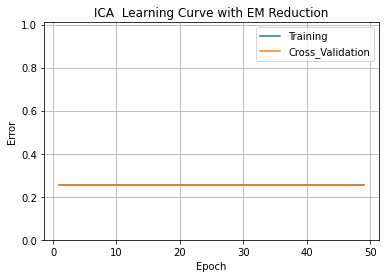

<Figure size 432x288 with 0 Axes>

In [948]:
plot_lc("RP","ICA",ica_data)
plot_lc("RP","K-means",ica_data_km)
plot_lc("RP","RP",ica_data_em)

## Pca NN 

In [949]:
nn= MLPClassifier( max_iter=19 ,
                                             solver ="adam",
                                             activation="relu",
                                             alpha=0.42858571428571435,
                                             learning_rate="invscaling",
                                             random_state = 12, 
                                             )

In [1023]:
def iterate_rp(trans_, data, iterations):
    total_variance = []
    for i in range(iterations):
        if i== 0 :
            rp_l = trans_.fit_transform(data)
        else:
            rp_l = trans_.fit_transform(rp_l)
        #         print(rp_l.var())
        total_variance.append(rp_l.var())
    col_nme = [f"Comp {i+1}" for i in range(rp_l.shape[1]) ]
    return pd.DataFrame(rp_l, columns = col_nme) 

def dim_red_to_df(trans_, data, dim_type, rp_iter, y=None):
    
    if dim_type.lower() == "lda":
        dim_red_data = trans_.fit_transform(data, y)
        col_name = [f"Comp {i+1}" for i in range(dim_red_data.shape[1]) ]
        df = pd.DataFrame(dim_red_data, columns = col_name)
        df["dim_type"]= dim_type
        df["target"]=y
        return df , trans_
    
    elif dim_type.lower() == "rp":
        print(data.shape)
        df = iterate_rp(trans_, data, rp_iter)
        df["dim_type"]= dim_type
        df["target"]=y
        return df , trans_
        
    else:
        print(data.shape)
        dim_red_data = trans_.fit_transform(data)
        col_name = [f"Comp {i+1}" for i in range(dim_red_data.shape[1]) ]
        df = pd.DataFrame(dim_red_data, columns = col_name)
        df["dim_type"]= dim_type
        df["target"]=y
        return df , trans_
    
    
    
def apply_dimension_reduction(n_comp, data, rp_iter, y=None):
    pca = PCA(n_components=n_comp)
    ica = FastICA(n_components=n_comp,whiten=True,max_iter=500)
    lda = LinearDiscriminantAnalysis()
    rp = random_projection.GaussianRandomProjection( n_components=n_comp)
    
    
    pca_df, pca_t =  dim_red_to_df(pca, data, "PCA",rp_iter,y)
    ica_df, ica_t=dim_red_to_df(ica, data, "ICA",rp_iter,y)
    rp_df, rp_t=dim_red_to_df(rp, data, "RP",rp_iter,y)
    lda_df, lda_t=dim_red_to_df(lda, data, "LDA",rp_iter,y)
    
    df_to_stack=[pca_df , ica_df,rp_df, lda_df]
    
    return pd.concat(df_to_stack), pca_t , ica_t,rp_t, lda_t

In [977]:
c_data_test= pca_census_pipeline.transform(X_c_test)

census_train_dim_red_test,p,i,r,l = apply_dimension_reduction(int((c_data_train.shape[1]*.85)//1),c_data_train, 2, y_c_train)

(26029, 108)
(26029, 108)
(26029, 108)


In [978]:
y_test_f = y_c_test.map({">50K":1, "<=50K":0})

# lda test

#  pca

In [1016]:
census_train_dim_red[~census_train_dim_red.target.isna()]

,Comp 1,Comp 2,Comp 3,Comp 4,Comp 5,Comp 6,Comp 7,Comp 8,Comp 9,Comp 10,Comp 11,Comp 12,Comp 13,Comp 14,Comp 15,Comp 16,Comp 17,Comp 18,Comp 19,Comp 20,Comp 21,Comp 22,Comp 23,Comp 24,Comp 25,Comp 26,Comp 27,Comp 28,Comp 29,Comp 30,Comp 31,Comp 32,Comp 33,Comp 34,Comp 35,Comp 36,Comp 37,Comp 38,Comp 39,Comp 40,Comp 41,Comp 42,Comp 43,Comp 44,Comp 45,Comp 46,Comp 47,Comp 48,Comp 49,Comp 50,Comp 51,Comp 52,Comp 53,Comp 54,Comp 55,Comp 56,Comp 57,Comp 58,Comp 59,Comp 60,Comp 61,Comp 62,Comp 63,Comp 64,Comp 65,Comp 66,Comp 67,Comp 68,Comp 69,Comp 70,Comp 71,Comp 72,Comp 73,Comp 74,Comp 75,Comp 76,Comp 77,Comp 78,Comp 79,Comp 80,Comp 81,Comp 82,Comp 83,Comp 84,Comp 85,Comp 86,Comp 87,Comp 88,Comp 89,Comp 90,Comp 91,dim_type,target
0,-0.570983,0.950413,-0.768851,-0.030579,-2.065594,-0.359129,-1.502917,-0.883901,-0.818698,-0.479954,-0.683553,-0.517616,1.394593,-2.299954,-1.023989,1.427491,-0.540227,0.194723,1.313148,-0.157744,-0.797616,0.958519,-0.158386,0.527904,0.414784,0.144370,0.171732,0.224700,-1.109557,-0.664607,0.391058,-0.308591,-1.153055,0.189689,-0.673827,-1.554837,-0.553250,0.312524,-0.589566,1.274845,0.807571,-0.014251,0.605980,-0.406338,0.269089,0.057226,-0.107009,-0.062946,0.042671,0.015097,-0.086457,-0.010899,-0.009012,0.282243,0.138618,0.078633,0.271935,-0.153172,0.027933,0.344198,-0.308859,-0.134954,0.550972,1.211189,0.452956,0.026195,-0.845417,-0.750828,0.123491,-0.387564,-0.318851,0.281174,1.596529,0.327267,0.379566,0.878715,0.426121,0.761931,0.407696,0.162460,0.557357,-0.464043,0.218009,-0.629484,0.407198,0.523253,-0.447496,0.189536,1.374358,0.622837,0.297568,PCA,<=50K
2,-1.958093,-0.579507,-0.379268,1.576918,-2.427543,0.888424,0.196661,-1.947201,-0.491594,-1.018493,1.173897,-0.073772,-2.005597,0.250941,0.831508,-0.962567,1.946977,-3.096553,-0.294570,-1.283265,0.828436,-0.801498,-0.214738,1.265975,0.423920,-0.814653,-1.091001,-0.115851,-0.251193,-0.799869,-0.652872,0.550506,0.351368,0.198482,-1.090284,-0.571638,-0.702794,0.465505,-0.305550,-0.668579,0.021618,0.079199,0.065495,0.452310,0.024323,-0.443670,0.309008,0.099973,-0.028900,-0.169579,0.211493,-0.172185,-0.155287,-0.143350,0.198961,-0.276902,-0.298882,0.271888,-0.272441,-0.602045,0.170429,-0.345064,-0.120815,-0.056076,0.465103,0.113982,-0.243193,-0.337667,0.787322,-0.332970,0.204861,0.143278,-0.582562,0.674347,0.186369,-0.226274,-0.154422,0.449203,0.134745,-0.289219,-0.260093,0.627356,1.087302,-0.673549,0.765852,0.547966,-0.930029,-0.255424,-0.200719,-0.651931,-0.931597,PCA,<=50K
3,-4.189257,1.443315,-0.173083,-0.884195,1.557550,-2.573696,1.187006,1.469930,-0.706659,-0.021699,2.645221,-1.246256,-0.841562,-0.444335,0.341088,-0.266582,-0.426160,-1.041002,0.387799,-0.406861,-0.522427,0.929770,0.403863,1.601644,0.510681,1.095990,-0.588427,0.420448,-0.256343,-0.440102,-1.872003,0.023082,-0.547330,1.753708,1.474925,0.038153,0.083726,-0.136336,-0.376259,-0.874362,-0.560090,0.690948,-0.319959,0.437027,-0.176865,-0.524697,0.350622,-0.083436,0.194958,-0.123582,0.027892,-0.442070,0.199975,0.021079,0.359331,-0.294079,-0.218801,-0.076974,-0.050519,0.137699,0.635898,0.535384,-0.391769,-0.201413,-0.169643,0.387296,1.228874,-0.220648,-0.181150,-0.118111,-1.424284,-0.997022,-0.574705,0.822967,0.021088,0.270338,-0.339812,0.011979,0.159419,-0.435460,-0.612704,0.518053,0.235598,0.394239,-0.495320,-0.666880,-0.074081,0.054184,-1.799209,-0.789598,-0.518501,PCA,<=50K
5,1.947734,1.783610,-1.029774,-0.183733,-0.503029,-0.699336,0.482521,-0.580804,-0.039942,-0.927627,-0.789559,0.447793,0.811134,-0.289980,-0.078759,-0.717187,-0.270371,-0.252534,0.017773,0.687374,0.872687,-0.224035,0.507756,-0.505370,0.657704,0.003030,-0.332715,0.415747,-0.230631,0.347484,-0.440009,0.280605,0.087809,-0.214683,0.107914,0.017777,0.141289,0.146621,-0.124065,0.126348,-0.136210,0.029283,-0.203555,0.183437,-0.099294,-0.015463,-0.024660,0.042287,0.025227,-0.013812,0.019911,0.040082,0.017914,-0.026310,0.099596,-0.018329,0.064042,-0.321753,0.010093,-0.078580,-0.039567,-0.126260,-0.067091,-0.431410,-0.003678,-0.

In [1029]:
x,y=get_model_data(census_train_dim_red_train[~census_train_dim_red_train.target.isna()], [c for c in census_train_dim_red_train.columns if "Comp" in c], "PCA")

In [1038]:
x

,Comp 1,Comp 2,Comp 3,Comp 4,Comp 5,Comp 6,Comp 7,Comp 8,Comp 9,Comp 10,Comp 11,Comp 12,Comp 13,Comp 14,Comp 15,Comp 16,Comp 17,Comp 18,Comp 19,Comp 20,Comp 21,Comp 22,Comp 23,Comp 24,Comp 25,Comp 26,Comp 27,Comp 28,Comp 29,Comp 30,Comp 31,Comp 32,Comp 33,Comp 34,Comp 35,Comp 36,Comp 37,Comp 38,Comp 39,Comp 40,Comp 41,Comp 42,Comp 43,Comp 44,Comp 45,Comp 46,Comp 47,Comp 48,Comp 49,Comp 50,Comp 51,Comp 52,Comp 53,Comp 54,Comp 55,Comp 56,Comp 57,Comp 58,Comp 59,Comp 60,Comp 61,Comp 62,Comp 63,Comp 64,Comp 65,Comp 66,Comp 67,Comp 68,Comp 69,Comp 70,Comp 71,Comp 72,Comp 73,Comp 74,Comp 75,Comp 76,Comp 77,Comp 78,Comp 79,Comp 80,Comp 81,Comp 82,Comp 83,Comp 84,Comp 85,Comp 86,Comp 87,Comp 88,Comp 89,Comp 90,Comp 91
0,-0.570983,0.950413,-0.768851,-0.030579,-2.065594,-0.359129,-1.502917,-0.883901,-0.818698,-0.479954,-0.683553,-0.517616,1.394593,-2.299954,-1.023989,1.427491,-0.540227,0.194723,1.313148,-0.157744,-0.797616,0.958519,-0.158386,0.527904,0.414784,0.144370,0.171732,0.224700,-1.109557,-0.664607,0.391058,-0.308591,-1.153055,0.189689,-0.673827,-1.554837,-0.553250,0.312524,-0.589566,1.274845,0.807571,-0.014251,0.605980,-0.406338,0.269089,0.057226,-0.107009,-0.062946,0.042671,0.015097,-0.086457,-0.010899,-0.009012,0.282243,0.138618,0.078633,0.271935,-0.153172,0.027933,0.344198,-0.308859,-0.134954,0.550972,1.211189,0.452956,0.026195,-0.845417,-0.750828,0.123491,-0.387564,-0.318851,0.281174,1.596529,0.327267,0.379566,0.878715,0.426121,0.761931,0.407696,0.162460,0.557357,-0.464043,0.218009,-0.629484,0.407198,0.523253,-0.447496,0.189536,1.374358,0.622837,0.297568
2,-1.958093,-0.579507,-0.379268,1.576918,-2.427543,0.888424,0.196661,-1.947201,-0.491594,-1.018493,1.173897,-0.073772,-2.005597,0.250941,0.831508,-0.962567,1.946977,-3.096553,-0.294570,-1.283265,0.828436,-0.801498,-0.214738,1.265975,0.423920,-0.814653,-1.091001,-0.115851,-0.251193,-0.799869,-0.652872,0.550506,0.351368,0.198482,-1.090284,-0.571638,-0.702794,0.465505,-0.305550,-0.668579,0.021618,0.079199,0.065495,0.452310,0.024323,-0.443670,0.309008,0.099973,-0.028900,-0.169579,0.211493,-0.172185,-0.155287,-0.143350,0.198961,-0.276902,-0.298882,0.271888,-0.272441,-0.602045,0.170429,-0.345064,-0.120815,-0.056076,0.465103,0.113982,-0.243193,-0.337667,0.787322,-0.332970,0.204861,0.143278,-0.582562,0.674347,0.186369,-0.226274,-0.154422,0.449203,0.134745,-0.289219,-0.260093,0.627356,1.087302,-0.673549,0.765852,0.547966,-0.930029,-0.255424,-0.200719,-0.651931,-0.931597
3,-4.189257,1.443315,-0.173083,-0.884195,1.557550,-2.573696,1.187006,1.469930,-0.706659,-0.021699,2.645221,-1.246256,-0.841562,-0.444335,0.341088,-0.266582,-0.426160,-1.041002,0.387799,-0.406861,-0.522427,0.929770,0.403863,1.601644,0.510681,1.095990,-0.588427,0.420448,-0.256343,-0.440102,-1.872003,0.023082,-0.547330,1.753708,1.474925,0.038153,0.083726,-0.136336,-0.376259,-0.874362,-0.560090,0.690948,-0.319959,0.437027,-0.176865,-0.524697,0.350622,-0.083436,0.194958,-0.123582,0.027892,-0.442070,0.199975,0.021079,0.359331,-0.294079,-0.218801,-0.076974,-0.050519,0.137699,0.635898,0.535384,-0.391769,-0.201413,-0.169643,0.387296,1.228874,-0.220648,-0.181150,-0.118111,-1.424284,-0.997022,-0.574705,0.822967,0.021088,0.270338,-0.339812,0.011979,0.159419,-0.435460,-0.612704,0.518053,0.235598,0.394239,-0.495320,-0.666880,-0.074081,0.054184,-1.799209,-0.789598,-0.518501
5,1.947734,1.783610,-1.029774,-0.183733,-0.503029,-0.699336,0.482521,-0.580804,-0.039942,-0.927627,-0.789559,0.447793,0.811134,-0.289980,-0.078759,-0.717187,-0.270371,-0.252534,0.017773,0.687374,0.872687,-0.224035,0.507756,-0.505370,0.657704,0.003030,-0.332715,0.415747,-0.230631,0.347484,-0.440009,0.280605,0.087809,-0.214683,0.107914,0.017777,0.141289,0.146621,-0.124065,0.126348,-0.136210,0.029283,-0.203555,0.183437,-0.099294,-0.015463,-0.024660,0.042287,0.025227,-0.013812,0.019911,0.040082,0.017914,-0.026310,0.099596,-0.018329,0.064042,-0.321753,0.010093,-0.078580,-0.039567,-0.126260,-0.067091,-0.431410,-0.003678,-0.192226,0.202028,0.158160,0.163309,0.361315,0.2

In [1030]:
x_t,y_t=get_model_data(census_train_dim_red_test, [c for c in census_train_dim_red_train.columns if "Comp" in c], "PCA")

In [1027]:
census_train_dim_red_train,p,i,r,l = apply_dimension_reduction(int((c_data_train.shape[1]*.85)//1),c_data_train, 2, y_c_train)

(26029, 108)
(26029, 108)
(26029, 108)


In [1173]:
census_clusters.target

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
5        0.0
6        0.0
7        1.0
8        0.0
9        1.0
10       1.0
11       1.0
12       1.0
13       1.0
14       1.0
15       1.0
16       1.0
17       1.0
18       1.0
19       1.0
20       1.0
21       0.0
22       0.0
23       0.0
24       0.0
25       0.0
26       0.0
27       0.0
28       1.0
29       1.0
30       1.0
31       1.0
32       1.0
33       1.0
34       1.0
35       1.0
36       1.0
37       1.0
38       1.0
39       1.0
40       1.0
41       1.0
42       1.0
43       1.0
44       0.0
45       1.0
46       0.0
47       0.0
48       0.0
49       0.0
        ... 
32487    0.0
32488    0.0
32489    0.0
32490    0.0
32491    0.0
32492    0.0
32493    0.0
32494    0.0
32495    0.0
32496    0.0
32497    0.0
32498    0.0
32499    0.0
32500    0.0
32501    0.0
32502    0.0
32503    0.0
32504    0.0
32505    0.0
32506    0.0
32507    0.0
32508    0.0
32509    1.0
32510    0.0
32511    1.0
32512    0.0

In [1174]:
ica_yo = census_clusters[census_clusters.dim_type=="ICA"].dropna()

In [1176]:
yo_col = [c for c in ica_yo.columns if "Comp" in c]

In [1179]:
census_clusters[census_clusters.dim_type=="ICA"].dropna()
nn= MLPClassifier( max_iter= 30,solver ="adam", alpha=.32    )
nn.fit(ica_yo[yo_col],ica_yo.target)

print("ica ", nn.score(ica_yo[yo_col],ica_yo.target))



ica  0.7590502260634208


In [ ]:
census_clusters[census_clusters.dim_type=="ICA"].dropna()
nn= MLPClassifier( max_iter= 30,solver ="adam", alpha=.32    )
nn.fit(ica_yo[yo_col],ica_yo.target)

print("pca ", nn.score(p.transform(c_data_test), y_test_f))



In [1058]:
nn= MLPClassifier( max_iter= 30,solver ="adam", alpha=.32    )
nn.fit(x,y.map({">50K":1, "<=50K":0}))

print("pca ", nn.score(p.transform(c_data_test), y_test_f))

pca  0.7590657652120467


In [1059]:
sum(y.map({">50K":1, "<=50K":0}))

5286

## Create time tables time plots 

In [1062]:
base_data.fit_time.cumsum()

0     0.319243
1     2.473223
2     6.453006
3    12.226482
4    19.920373
5    29.365764
Name: fit_time, dtype: float64

In [1117]:
def enrich(df,dim_type):
    df['cumulative_runtime'] = df.fit_time.cumsum()
    df['dim_type']= dim_type
    return df


In [1180]:
stack= [enrich(base_data, "Base"),
enrich(pca_data, "PCA"),
enrich(ica_data, "ICA"),
enrich(rp_data, "RP"),
enrich(lda_data, "LDA"),
enrich(pca_data_em, "EM"),
enrich(pca_data_km, "KM")]


In [1181]:
final_plot = pd.concat(stack)

In [1182]:
final_plot

,Training,Cross_Validation,epoch,fit_time,score_time,cumualtive_runtime,dim_type,cumulative_runtime
0,0.155461,0.159322,1,0.343720,0.037807,0.343720,Base,0.343720
1,0.144377,0.151216,3,0.520942,0.037957,0.864662,Base,0.864662
2,0.139623,0.149794,5,0.707171,0.037847,1.571834,Base,1.571834
3,0.135522,0.148565,7,0.801365,0.033721,2.373199,Base,2.373199
4,0.133169,0.147259,9,0.899627,0.031068,3.272826,Base,3.272826
5,0.131296,0.146798,11,1.040005,0.030965,4.312831,Base,4.312831
6,0.129173,0.146414,13,1.181358,0.030883,5.494189,Base,5.494189
7,0.126628,0.148219,15,1.360530,0.031713,6.854718,Base,6.854718
8,0.126081,0.147413,17,1.519838,0.031956,8.374556,Base,8.374556
9,0.125331,0.147912,19,1.659073,0.031712,10.033629,Base,10.033629


In [1183]:
final_plot.groupby("dim_type").plot

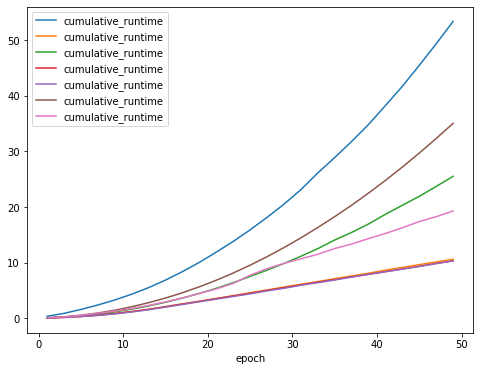

In [1123]:
fig, ax = plt.subplots(figsize=(8,6))
bp = final_plot[["cumulative_runtime","epoch","dim_type"]].groupby('dim_type').plot(x="epoch", y="cumulative_runtime", ax=ax)

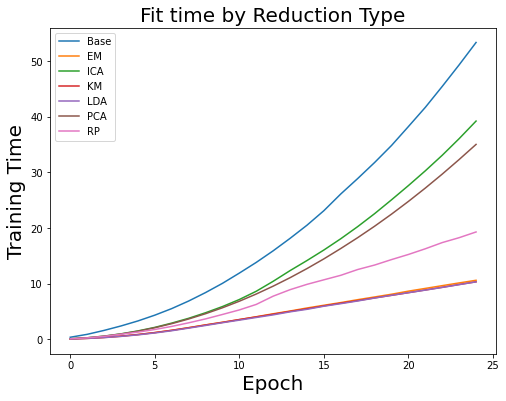

In [1221]:



fig, ax = plt.subplots(figsize=(8,6))
for label, df in final_plot.groupby('dim_type'):
    ax = df.cumulative_runtime.plot(x="epoch", y="cumulative_runtime", ax=ax,label=label )


ax.set_ylabel("Training Time", fontsize=20)
ax.set_xlabel("Epoch", fontsize=20)
plt.title("Fit time by Reduction Type", fontsize=20)
plt.legend()
plt.savefig("fit_time_final_big.png")            
                               

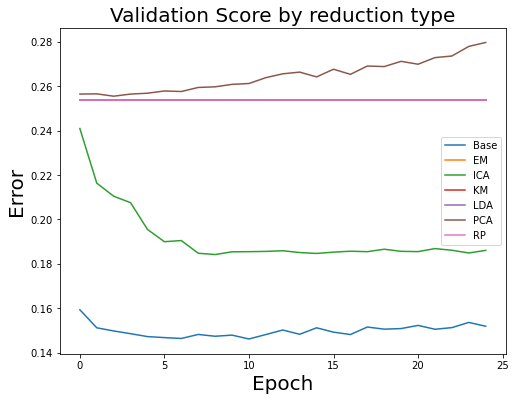

In [1222]:
fig, ax = plt.subplots(figsize=(8,6))
for label, df in final_plot.groupby('dim_type'):
    ax = df.Cross_Validation.plot(x="epoch", y="Cross_Validation", ax=ax,label=label, title="Validation Score")
ax.set_ylabel("Error", fontsize=20)
ax.set_xlabel("Epoch", fontsize=20)
plt.title("Validation Score by reduction type", fontsize=20)
plt.legend()
plt.legend()
plt.savefig("validation_all_final_big.png")